In [2]:
#pip install --no-cache-dir --default-timeout=1000 pandas numpy==1.26.4 seaborn==0.9.0 matplotlib scikit-learn pmdarima portalocker>=2.0.0 plotly dash

In [3]:
#%pip install --no-cache-dir --default-timeout=1000 torch==2.3.0+cpu torchdata==0.9.0+cpu torchtext==0.18.0+cpu --index-url https://download.pytorch.org/whl/cpu

In [4]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/home/giacomo_lini/GENAI_IBM/.venv/lib/python3.9/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/giacomo_lini/GENAI_IBM/.venv/lib/python3.9/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/giacomo_lini/GENAI_IBM/.venv/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWa

Defining Helper Functions

In [5]:
def plot(cost, acc):
    """Plot training loss and accuracy."""
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(cost, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(acc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Text Classification

In [6]:
train_iter= iter(AG_NEWS(split="train"))

In [9]:
y,text= next((train_iter))
print(y, "-",text)

ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

3 - Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.


'Business'

### Create Tokens

In [10]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")

Vocabulary size: 95811
Sample tokens: ['zzzzzz', 'zzz', 'zyprexa', 'zwiki', 'zvidauri', 'zvezda', 'zurich-kloten', 'zurab', 'zuloaga', 'zuhua']


In [11]:
# token indices

vocab(['hello', 'world'])

[12544, 50]

## Dataset Training Test Valid Split

In [12]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Loader

In [14]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

we now build a ```collate_batch``` function to build together custom batches from indivudal examples

In [15]:
def collate_batch(batch):
    """Collate function to be used in DataLoader.
     This function processes a batch of data samples and prepares them for input to the model.
     It converts text data into token indices, creates offsets for variable-length sequences"""
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [16]:
BATCH_SIZE = 64

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [17]:
label, text, offsets = next(iter(valid_dataloader))

label, text, offsets

(tensor([2, 1, 0, 0, 3, 2, 0, 3, 2, 1, 3, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2,
         3, 3, 0, 1, 2, 2, 2, 3, 2, 0, 1, 3, 0, 2, 0, 2, 0, 0, 2, 3, 3, 1, 3, 0,
         3, 1, 1, 1, 3, 3, 2, 2, 3, 1, 2, 1, 3, 2, 1, 0]),
 tensor([  58, 1241,  338,  ...,  826,   12,    1]),
 tensor([   0,   41,   80,  121,  157,  195,  223,  249,  278,  329,  369,  406,
          450,  562,  605,  646,  682,  744,  774,  809,  849,  892,  928,  967,
          999, 1028, 1062, 1118, 1156, 1196, 1223, 1282, 1321, 1355, 1403, 1434,
         1474, 1514, 1557, 1608, 1653, 1703, 1760, 1832, 1857, 1886, 1923, 1964,
         2006, 2076, 2125, 2165, 2197, 2246, 2300, 2348, 2382, 2427, 2469, 2515,
         2560, 2607, 2643, 2682]))

## Neural Network

In [18]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        """
        Initialize the TextClassificationModel with embedding and fully connected layers.
        embedding: Embedding layer to convert token indices into dense vectors.
        fc: Fully connected layer to map the embeddings to class scores.
        weights are initialized using the init_weights method.
        """
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.init_weights()

    def init_weights(self):
        """Initialize weights of the embedding and fully connected layers."""
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        """
        Forward pass of the model.
        text: Input text data as token indices.
        offsets: Offsets to handle variable-length sequences.
        Returns the output scores for each class.
        """
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [19]:
emsize=64 # Size of each embedding vector
vocab_size = len(vocab) #setting the size of vocabulary
num_classes = len(ag_news_label) #fetching the number of classes from the label dictionary

In [20]:
num_classes, vocab_size, emsize

(4, 95811, 64)

In [21]:
model = TextClassificationModel(vocab_size, emsize, num_classes).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [23]:
predicted_label = model(text, offsets)

predicted_label.shape

torch.Size([64, 4])

In [24]:
def predict(text, text_pipeline):
    """Predict the class label for a given text input.
    text: Input text string to be classified.
    text_pipeline: Function to convert text into token indices.
    Returns the predicted class label as a string.
    """
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        offsets = torch.tensor([0])
        output = model(text, offsets)
        return ag_news_label[output.argmax(1).item() + 1]

In [26]:
predict("Tadej Pogacar is one of the greatest bike riders ever", text_pipeline)

'World'

In [27]:
def evaluate(dataloader):
    """Evaluate the model on a given dataloader.
    dataloader: DataLoader containing the dataset to be evaluated.
    Returns the accuracy of the model on the dataset.
    """
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [28]:
evaluate(test_dataloader)

0.25

the model is still making random predictions as it has not been trained yet

## Training

In [29]:
#set learning rate
LR = 0.1

#set optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

#the scheduler adjusts the learning rate during training after every epoch to improve convergence
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [30]:
EPOCHS = 10

cumulative_loss_list = []
acc_epoch = []
acc_old = 0

#tqdm measures the progreess of the training loop
for epoch in tqdm(range(EPOCHS)):
    model.train()
    cumulative_loss = 0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        #gradient clipping to prevent exploding gradients
        #it introduces a threshold value (0.1 in this case) and scales down the gradients if their norm exceeds this threshold.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cumulative_loss += loss.item()
    
    cumulative_loss_list.append(cumulative_loss)
    acc_val = evaluate(valid_dataloader)
    acc_epoch.append(acc_val)

    #if accuracy is improving, save the model
    if acc_val > acc_old:
        acc_old = acc_val
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 10/10 [06:38<00:00, 39.81s/it]


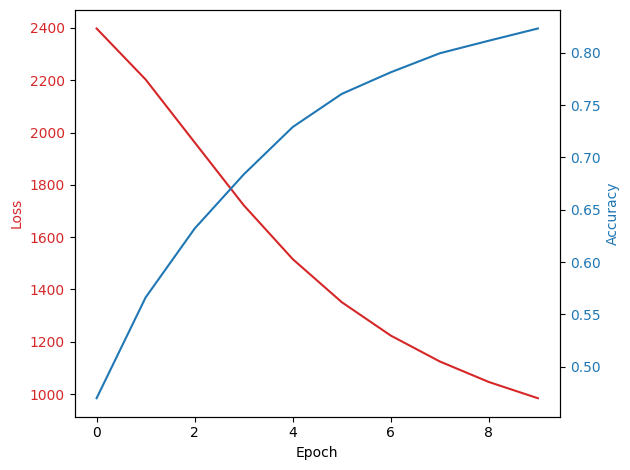

In [31]:
plot(cumulative_loss_list, acc_epoch)

In [32]:
evaluate(test_dataloader)

0.8131578947368421

## Embedding Visualization

In [35]:
batch = next(iter(valid_dataloader))

label, text, offsets = batch

text = text.to(device)
offsets = offsets.to(device)

embedded = model.embedding(text, offsets)

embeddings_numpy = embedded.cpu().detach().numpy()

embedded_3d = TSNE(n_components=3, random_state=0).fit_transform(embeddings_numpy)

trace = go.Scatter3d(
    x=embedded_3d[:, 0],
    y=embedded_3d[:, 1],
    z=embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.cpu().numpy(),  # Color by label
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f'Label: {ag_news_label[l.item() + 1]}' for l in label]  # Hover text
)

layout = go.Layout(
    title='3D Visualization of Text Embeddings',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Excercises

In [ ]:
# load pre trained model

model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [42]:
new_articles = [
    "Apple is looking at buying U.K. startup for $1 billion",
    "Local team wins championship after thrilling final",
    "New advancements in AI technology are emerging",
    "Stock markets soar as economic outlook improves",
    "Pogacar wins the Tour de France yet again"
]

In [43]:
for article in new_articles:
    print(f'Text: "{article}"\nPredicted label: "{predict(article, text_pipeline)}"\n')

Text: "Apple is looking at buying U.K. startup for $1 billion"
Predicted label: "Business"

Text: "Local team wins championship after thrilling final"
Predicted label: "Sports"

Text: "New advancements in AI technology are emerging"
Predicted label: "Sci/Tec"

Text: "Stock markets soar as economic outlook improves"
Predicted label: "Business"

Text: "Pogacar wins the Tour de France yet again"
Predicted label: "Sports"

